In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy.linalg import eig
import seaborn as sns
from scipy.stats import median_abs_deviation

In [2]:
data = pd.read_csv('./data/apriltaxis_sample.csv')
data.head()

,Trip Seconds,Trip Miles,Fare,Tips,Extras,Trip Total,Payment Type,Company,Weekend,Daytime
0,2305,17.99,45.75,10.05,4.0,60.30,Credit Card,Chicago Independents,False,True
1,462,1.15,9.00,2.15,0.0,11.15,Mobile,Taxicab Insurance Agency Llc,False,False
2,725,1.83,8.75,0.00,1.5,10.25,Cash,Chicago Independents,True,True
3,2881,17.86,46.00,10.10,4.0,60.60,Credit Card,Taxicab Insurance Agency Llc,False,True
4,818,3.61,12.50,2.60,0.0,15.60,Credit Card,Sun Taxi,True,True


### 0. Data Preprocessing

As PCA can only be applied to continuous data, we will store continuous variables to a separate dataset.

In [3]:
df_continuous = data[['Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Extras', 'Trip Total']]

Let's check the number of outliers and make a decision about its presence in the dataset.

In [4]:
for column in df_continuous:
    Q3 = np.quantile(df_continuous[column], 0.75)
    Q1 = np.quantile(df_continuous[column], 0.25)
    threshold = 1.5*(Q3 - Q1)
    outliers = sum((df_continuous[column] > Q3 + threshold) | (df_continuous[column] < Q1 - threshold))
    print(f'There are {outliers} outliers in the column {column}.')

There are 21 outliers in the column Trip Seconds.
There are 2 outliers in the column Trip Miles.
There are 3 outliers in the column Fare.
There are 57 outliers in the column Tips.
There are 172 outliers in the column Extras.
There are 2 outliers in the column Trip Total.


The column "Extras" has more than 20% outliers, and removing them may seem too critical for the following analysis. By retaining the outliers, the results of the PCA would be able to reflect the full variability of the data, including common patterns as well as rare extreme cases.

Next, we must decide whether to work with covariance or correlation matrix in our PCA analysis. To prove the necessity of the standardization of the data, we will check if the data is similar in measurement scale and variance. Looking at the original dataframe, we notice that four of our variables are measured in dollars, one of them is measured in miles, and the last one - in seconds. 
Below there are the boxplots to check the variance.

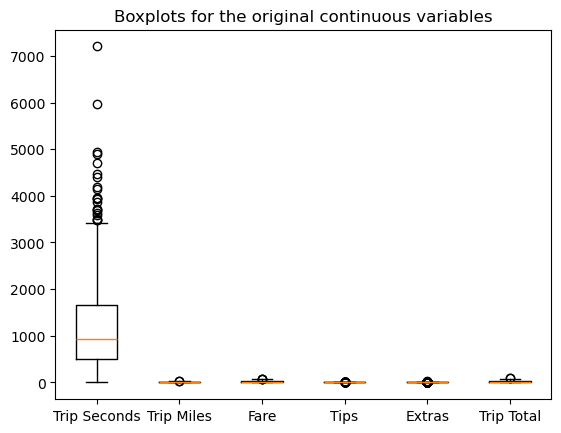

In [5]:
plt.boxplot(df_continuous, labels=df_continuous.columns)
plt.title('Boxplots for the original continuous variables')
plt.show()

The variances are not commensurate: the variable "Trip Seconds" measured in seconds has the biggest variance that can affect the result of the PCA. Thus, we will standardize the data and work with the correlation matrix.

In [6]:
X = df_continuous.values
X = StandardScaler().fit_transform(X)
np.mean(X), np.std(X) # check if correct

(2.9235872981795786e-17, 0.9999999999999999)

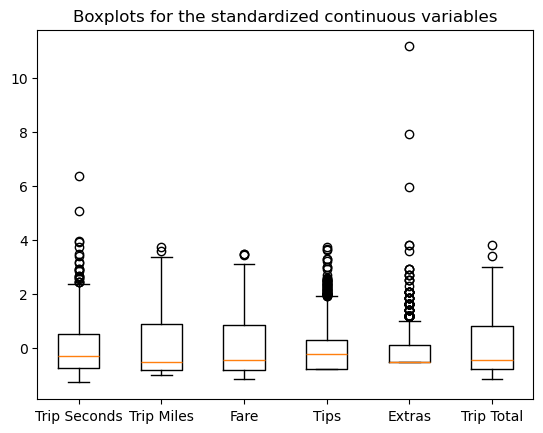

In [7]:
plt.boxplot(X, labels=df_continuous.columns)
plt.title('Boxplots for the standardized continuous variables')
plt.show()

### 1. PCA
#### 1.1. Select the number of principal components

First, we need to calculate the correlation matrix as our data is standardized.

In [8]:
np.set_printoptions(precision=5)
R = np.corrcoef(X, rowvar=False)
R

array([[1.     , 0.73381, 0.80549, 0.47969, 0.38941, 0.78902],
       [0.73381, 1.     , 0.92731, 0.55292, 0.49676, 0.91561],
       [0.80549, 0.92731, 1.     , 0.57049, 0.48644, 0.97548],
       [0.47969, 0.55292, 0.57049, 1.     , 0.48925, 0.7165 ],
       [0.38941, 0.49676, 0.48644, 0.48925, 1.     , 0.60956],
       [0.78902, 0.91561, 0.97548, 0.7165 , 0.60956, 1.     ]])

Note that all pairwise correlations are positive.

Second, we find the eigen values and eigen vectors of the correlation matrix above.

In [9]:
eig_vals, eig_vecs = eig(R)
print(f'Eigen values: {eig_vals}') 
print(f'Eigen vectors: {eig_vecs}')

Eigen values: [4.39014e+00 7.40594e-01 4.98151e-01 2.89799e-01 8.12207e-02 9.13731e-05]
Eigen vectors: [[-0.39818 -0.37714  0.08163  0.81646 -0.16106  0.00096]
 [-0.44037 -0.21866  0.11521 -0.47008 -0.72387 -0.0036 ]
 [-0.45421 -0.26237  0.07786 -0.24517  0.53023 -0.61445]
 [-0.34919  0.431   -0.80642  0.08922 -0.1033  -0.15284]
 [-0.31069  0.74443  0.56821  0.12986 -0.02929 -0.09329]
 [-0.47197 -0.03424 -0.02872 -0.16577  0.39672  0.76836]]


Spectral decomposition for the correlation matrix R has the following form:
$$
R = \tilde{T}\tilde{Λ}\tilde{T'},
$$
where $\tilde{T}$ is a matrix with eigenvectors of R, $\tilde{Λ}$ is a diagonal matrix with eigevalues on the diagonal, $\tilde{T'}$ is a transpose of T.

Let's manually calculate the spectral decomposition of a matrix R.

In [10]:
A = np.zeros([6, 6])
for i in range(len(A)):
    A[i][i] = eig_vals[i]
T = eig_vecs

Here T is a matrix with eigenvectors of R, A is a diagonal matrix with eigevalues on the diagonal.
To check if a spectral decomposition went correctly, we multiply the three matrices.

In [11]:
R_check = np.dot(np.dot(T, A), T.T)
R_check

array([[1.     , 0.73381, 0.80549, 0.47969, 0.38941, 0.78902],
       [0.73381, 1.     , 0.92731, 0.55292, 0.49676, 0.91561],
       [0.80549, 0.92731, 1.     , 0.57049, 0.48644, 0.97548],
       [0.47969, 0.55292, 0.57049, 1.     , 0.48925, 0.7165 ],
       [0.38941, 0.49676, 0.48644, 0.48925, 1.     , 0.60956],
       [0.78902, 0.91561, 0.97548, 0.7165 , 0.60956, 1.     ]])

Third, we calculate the percentage of variability that each of the principal components explains.

In [12]:
total_sample_var = np.trace(R)
explained_variance = [(i / total_sample_var)*100 for i in eig_vals]
pc_values = np.arange(len(R)) + 1
for i in range(len(R)):
    print(f'Principal component {pc_values[i]} explains {explained_variance[i]} of variability.')

Principal component 1 explains 73.16905475806101 of variability.
Principal component 2 explains 12.343234688272002 of variability.
Principal component 3 explains 8.302520542814102 of variability.
Principal component 4 explains 4.829988585841063 of variability.
Principal component 5 explains 1.353678539366568 of variability.
Principal component 6 explains 0.001522885645313117 of variability.


Based on the percentage of explained variability, we assume that we may have to take 1 or 2 first components as their sum is equal 85.5%. Although we want to take a look at other methods for discarding components.

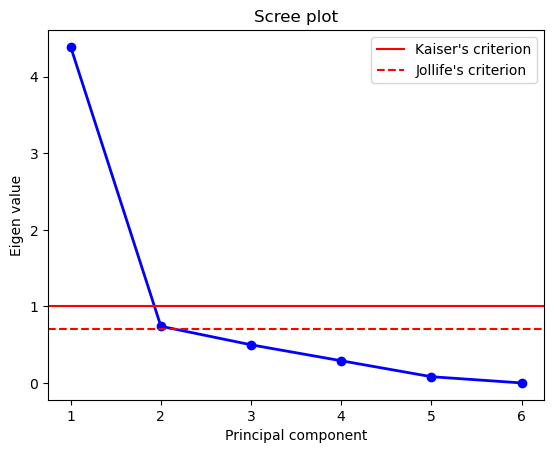

In [13]:
plt.plot(pc_values, eig_vals, 'o-', linewidth=2, color='blue')
plt.axhline(1, color='r', label="Kaiser's criterion")
plt.axhline(0.7, color='r', label="Jollife's criterion", linestyle='dashed')
plt.title('Scree plot')
plt.xlabel('Principal component')
plt.ylabel('Eigen value')
plt.legend()
plt.show()

From the plot above we derive the following conclusions:
- Cattell's scree graph suggests taking 1 principal component as the steepness of the slope decreases significantly from the 2nd to the 3d component;
- Kaiser's criterion (computed from R) suggests taking only the 1st component as its value is bigger than 1;
- Jollife's criterion (computed from R) suggests taking 2 principal components as their eigenvalues are bigger than 0.7.

Unfortunately, here we cannot use the Dimensionality test to check the number of components as our data is standardized. As two tests allow us to use 2 principal components, we would like to continue with them for educational purposes.

#### 1.2. Interpret the principal components

In [14]:
pc_weights = np.stack((T[:, 0], T[:, 1]))
print(pd.DataFrame(pc_weights,columns=df_continuous.columns,index = ['PC 1', 'PC 2']))

      Trip Seconds  Trip Miles      Fare      Tips    Extras  Trip Total
PC 1     -0.398182   -0.440375 -0.454209 -0.349186 -0.310694   -0.471968
PC 2     -0.377136   -0.218658 -0.262367  0.431004  0.744435   -0.034243


The first two components have the following form:

$$
\tilde{Y_1} = - 0.398182{X_1}^{*} - 0.440375{X_2}^{*}  - 0.454209{X_3}^{*} - 0.349186{X_4}^{*} - 0.310694{X_5}^{*} - 0.471968{X_6}^{*}
$$
$$
\tilde{Y_2} = - 0.377136{X_1}^{*} - 0.218658{X_2}^{*}  - 0.262367{X_3}^{*} + 0.431004{X_4}^{*} + 0.744435{X_5}^{*} - 0.034243{X_6}^{*}
$$

From $\tilde{Y_1}$ we see that all Xs contribute with negative weights to the first principal component. Such variables as "Trip Total", "Fare" and "Trip Miles" have the biggest magnitude and are related to the distance of a ride and its cost for a customer. 

From $\tilde{Y_2}$ we derive that the most influential variables for the second principal component are "Tips" and "Extras" that contribute with a positive sign. These variables generally represent some additional services taken during the ride (for "Extras" it can be baby passenger seat or toll road) and customer's satisfaction (for "Tips"). Also, these two variables have different relative direction with other Xs which makes us think that high values of them are associated with short and cheap rides.

To calculate the original observations represented in the new coordinate system of the first two principal components, we multiply:
$$
Y = XT
$$

In [15]:
Y1 = X@T[:, 0]
Y2 = X@T[:, 1]
Y = np.column_stack((Y1, Y2))

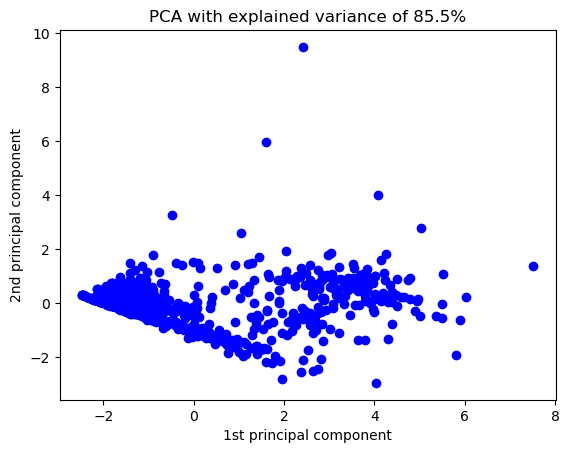

In [16]:
plt.scatter(Y1*(-1), Y2, color='blue')
plt.title('PCA with explained variance of 85.5%')
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
plt.show()

By changing the sign of the first principal component, we get that all variables contribute positively. On the scatter plot, it means that the rides on the right-hand side are larger both cost-wise and distance-wise. And the rides on the left-hand side are shorter and cheaper.
At the same time, rides that are located higher are associated with more extra services and lower - with less spending on extra services.
As the cumulative explained variance is higher than 85%, our PCA with two principal components seems to effectively summarize the data.

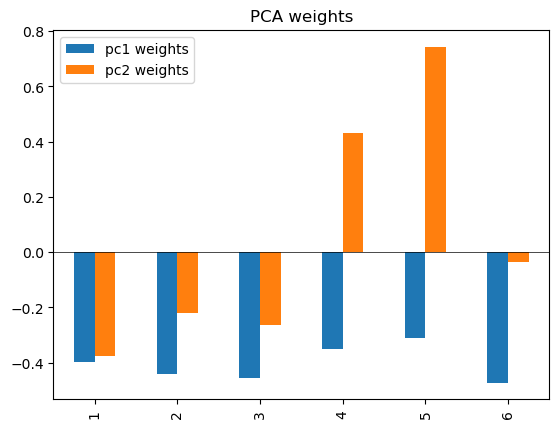

In [17]:
df_pc_weights = pd.DataFrame(pc_weights.T, columns=['pc1 weights', 'pc2 weights'], index=pc_values)
df_pc_weights.plot.bar()
plt.axhline(0, color='black', linewidth=0.5)
plt.title('PCA weights')
plt.show()

- On the bar plot, we see that both PC1 and PC2 contribute negatively to $X_1$ ("Trip Seconds"), and their magnitudes are close. This suggests that increasing the duration of the ride decreases the scores for both principal components. In practical terms, longer rides are negatively associated with both trip characteristics and service-level features. This can indicate that longer rides tend to have fewer extras or tips.
- We can witness the same pattern for the PC1 for all Xs: the first principal component contributes negatively to all of them. As any variable increases, the PC1 score decreases. We suggest that PC1 represents an overall pattern where these variables jointly describe trip "size".
- PC2 has a positive contribution to $X_4$ ("Tips") and $X_5$ ("Extras"), and the last one is a dominating feature for the second principal component. Unlike PC1, which distinguishes rides based on their "size", PC2 distinguishes rides based on additional characteristics. Thus, higher PC2 scores represent rides with more extras and tips, and lower PC2 scores represent rides with fewer or no extras and tips.

In [18]:
cross_correlations_Y1 = np.corrcoef(Y1, X.T)
cross_correlations_Y2 = np.corrcoef(Y2, X.T)
cross_corr = pd.DataFrame([cross_correlations_Y1[0][1:], cross_correlations_Y2[0][1:]], columns=df_continuous.columns, 
                          index=['Y1', 'Y2'])
cross_corr

,Trip Seconds,Trip Miles,Fare,Tips,Extras,Trip Total
Y1,-0.834298,-0.922703,-0.951689,-0.731637,-0.650987,-0.988898
Y2,-0.324555,-0.188172,-0.225787,0.370912,0.640644,-0.029469


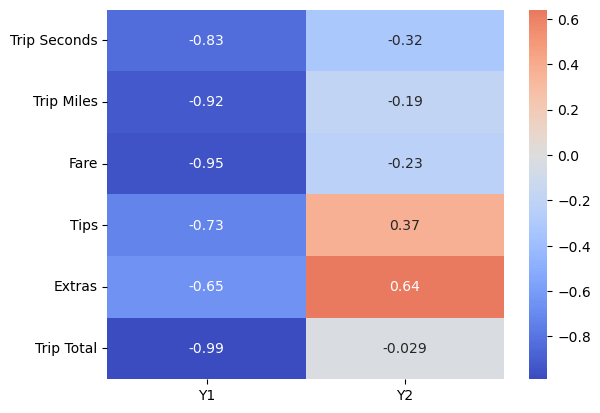

In [19]:
sns.heatmap(cross_corr.T, annot=True, center=0, cmap='coolwarm')
plt.show()

Cross-correlation and heatmap associated with it confirm our conclusions. We witness high negative correlations (less than -0.8) between X and the first component for four variables associated with ride characteristics, and also a negative but slightly less strong correlation for two other variables - "Tips" and "Extras". At the same time, they have a positive correlation with the second component.

#### 1.3. Study the stability of PCA

In order to analyze the contribution of each observation to the final model, we will design the stability test function. 
This test includes the following steps:
1) Exclude one row from the original dataset;
2) Recalculate PCA;
3) Project the removed row onto the principal components of the X with the excluded row;
4) Rebuild the configuration;
5) Compare the results calculating the Euclidean distance between the original PCA configuration and the transformed one.

In [20]:
def pca_stability(X, Y):
    n, p = X.shape 
    euclidean_dist = np.zeros((n, n))
    
    for i in range(X.shape[0]):
        exlud_x = X[i, :]
        X_excl = np.delete(X, i, axis=0)
        R = np.corrcoef(X_excl, rowvar=False)
        eig_vals, eig_vecs = eig(R)
        T = eig_vecs[:, :2]
        Y_excl = X_excl@T
        y = exlud_x@T
        Y_transformed = np.insert(Y_excl, i, y, axis=0)
        euclidean_dist[i, :] = np.linalg.norm(Y - Y_transformed, axis=1)
    return euclidean_dist

In [21]:
v = pca_stability(X, Y)
n = v.shape[0] 
stats = np.zeros((n, 6))

for i in range(n):
    stats[i, 0] = np.min(v[i, :])
    stats[i, 1] = np.max(v[i, :])
    stats[i, 2] = np.quantile(v[i, :], 0.50)
    stats[i, 3] = np.quantile(v[i, :], 0.75)
    stats[i, 4] = np.quantile(v[i, :], 0.90)
    stats[i, 5] = np.quantile(v[i, :], 0.95)

rowsummary = (np.mean(stats, axis=0), np.std(stats, axis=0), np.median(stats, axis=0), median_abs_deviation(stats, axis=0))
stats_summary = pd.DataFrame(rowsummary, index=['mean', 'median', 'std', 'mad'], 
                             columns=['min', 'max', 'median', '75th p', '90th p', '95th p'])
stats_summary

,min,max,median,75th p,90th p,95th p
mean,0.000027,0.013239,0.000919,0.001437,0.002464,0.003431
median,0.000041,0.042877,0.002564,0.003761,0.006257,0.009051
std,0.000012,0.005477,0.000393,0.000647,0.001091,0.001539
mad,0.000008,0.003687,0.000249,0.000421,0.000724,0.001018


From the table that summarizes Euclidian distances for all 800 observations, we notice that the median values are quite small (the mean of the median value is equal 0.0009). On the other hand, the median value for a maximum (0.042) suggests that there are observations that may influence the stability of PCA more significantly. Let's do the boxplots for the first 20 values.

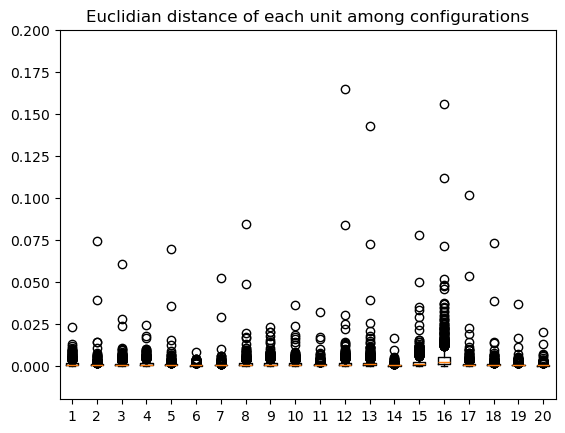

In [22]:
plt.boxplot(v[:, :20])
plt.ylim(-0.02, 0.2)
plt.title('Euclidian distance of each unit among configurations')
plt.show()

The plots above prove that the median of all distances for each observation lies close to 0, and data is heavily skewed because none of the variables can take negative values. At the same time, there are certain outliers, and its exclusion may affect PCA more than we expected. Among them are observations 12, 13, 15, 16, 17, and others. As we stated in the first part of this chapter, the decision to keep all the observations was based on the fact that we would potentially lose at least 20% of the information. 

As of now, we still consider these outliers important. Recalling the fact that the variables "Extras" and "Tips" had the highest number of outliers, we assume that their exclusion may significantly decrease the explained variance of PC2 to where both variables contribute with a positive sign.

In [23]:
def stability_regions(Y, num_rows=None):
    radius = stats[: ,4]*50
    theta = np.linspace(0, 2 * np.pi, 100)
    
    if num_rows is None:
        num_rows = len(Y)
    else:
        num_rows = min(num_rows, len(Y))
    
    for i in range(num_rows):
        if radius[i] > 0:
            plt.ylim(-3.5, 3.5) 
            plt.scatter(Y[i, 0], Y[i, 1], c='blue', zorder=3, s=5)
            circle_x = Y[i, 0] + np.cos(theta) * radius[i]
            circle_y = Y[i, 1] + np.sin(theta) * radius[i]
            plt.plot(circle_x, circle_y, color='black', linewidth=1)
            plt.text(Y[i, 0] + 0.07, Y[i, 1] + 0.07, f"{i+1}", fontsize=8, color='black')
            plt.title("PCA Representation with 90% stability regions")
            plt.xlabel("1st principal component")
            plt.ylabel("2nd principal components")
        else:
            pass

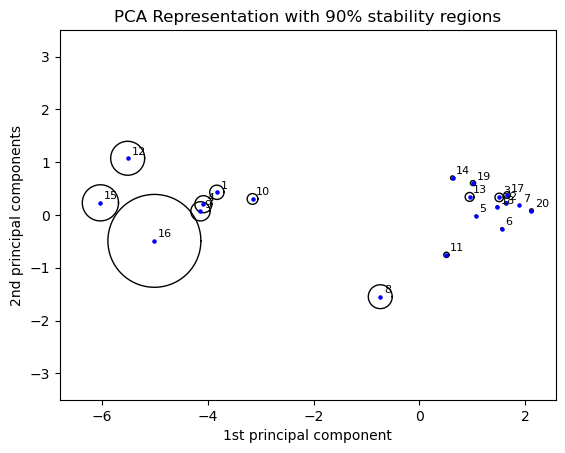

In [24]:
stability_regions(Y, num_rows=20)

Even on a small number of observations, we notice that stability regions differ significantly for any particular case. Thus, rides with small circles indicate that their removal will not affect the result of PCA dramatically. However, large regions around the observations point to influential rides that may affect PCA results. As we have seen on the boxplot graph: observations 12, 15, and 16 have the biggest 90% stability regions. Although observation number 12 has the furthest outlier, observation 16 has a bigger skewness in general that is represented by the biggest stability region.

### 2. Clustering
#### 2.1. Choose the clustering method

In [40]:
from sklearn.preprocessing import LabelEncoder
from FastKmedoids.models import FoldFastKmedoidsGGower
from sklearn.manifold import MDS
from PyDistances.mixed import GGowerDistMatrix
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap

Our dataset has 800 observations, meaning that we will not be able to use hierarchical clustering to divide it into groups. In our project, we will use partitional clustering, which allows us to work with big datasets. Inside this family of methods, we can't apply the k-means as our variables are highly correlated which we have seen in the first part of the project meaning that we cannot compute the Euclidian distance in this case. As the dataset includes a mix of continuous, binary, and categorical variables, we will use the **k-medoids** method.

Before running the clustering algorithm, it is necessary to encode binary and categorical variables. Here, it seems important to save the original labels and their corresponding encodings. Also, we make sure that the columns in the dataset follow the order (required by FoldFastKmedoidsGGower): quantitative, binary and multi-class columns.

In [25]:
boolean_columns = data.select_dtypes(include=['bool']).columns
data[boolean_columns] = data[boolean_columns].astype(int)
categorical_columns = data.select_dtypes(include=['object']).columns

inversed = []

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    mapping_df = pd.DataFrame({'Encoded': range(len(le.classes_)), col: le.classes_})
    inversed.append(mapping_df)

inversed = pd.concat(inversed, axis=0)

data = data[['Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Extras', 'Trip Total', 
             'Weekend', 'Daytime', 'Payment Type', 'Company']]
data.head()

,Trip Seconds,Trip Miles,Fare,Tips,Extras,Trip Total,Weekend,Daytime,Payment Type,Company
0,2305,17.99,45.75,10.05,4.0,60.30,0,1,1,4
1,462,1.15,9.00,2.15,0.0,11.15,0,0,2,17
2,725,1.83,8.75,0.00,1.5,10.25,1,1,0,4
3,2881,17.86,46.00,10.10,4.0,60.60,0,1,1,17
4,818,3.61,12.50,2.60,0.0,15.60,1,1,1,15


#### 2.2. Implement the k-medoids algorithm

Next, we will work with the package FastKmedoids from Python which implements Fast-K-medoids algorithm based on the Generalized Gower distance. As parameters, we set the following:

- method='pam': this algorithm finds the object with the smallest dissimilarity to all others in the cluster. It differs from, for example, k-means by the fact that medoids are the actual point of our dataset whereas for k-means centroid may be any point, not exactly the one from the data.
- d1='robust_mahalanobis': for quantitative variables, Robust Mahalanobis distance is used as the assumption that the data is multivariate normal is not confirmed. Also, we have witnessed a lot of outliers while working with this dataset in the first part of the project.
- d2='sokal': for binary variables, we use the Sokal-Michener similarity coefficient as we suspect that the frequency of variables with response 0 in both units is meaningful in our analysis.
- d3='hamming': for multi-class categorical variables, Hamming similarity coefficient is used as it focuses on dissimilarity and gives a count of mismatches between the objects.

Also, we decided to use the K-fold algorithm of Fast-K-medoids to avoid the sensitiveness of the division into clusters and to get a more robust result.

Trying different numbers of clusters, we have found that the optimal would be 3. Later, we will be able to witness it in the plot.

In [26]:
quant_cols = ['Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Extras', 'Trip Total']
binary_cols = ['Weekend', 'Daytime']
multiclass_cols = ['Payment Type', 'Company']

p1 = len(quant_cols)
p2 = len(binary_cols)
p3 = len(multiclass_cols)

kfold_fast_kmedoids = FoldFastKmedoidsGGower(n_clusters=3, method='pam', init='random', max_iter=100, random_state=123,
                                             frac_sample_size=0.1, n_splits=10, shuffle=True, kfold_random_state=123,
                                             p1=p1, p2=p2, p3=p3, d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                                             robust_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20,
                                             fast_VG=False, VG_sample_size=1000, VG_n_samples=5)
kfold_fast_kmedoids.fit(X=data)
cluster_labels = kfold_fast_kmedoids.labels_

Clustering Folds: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


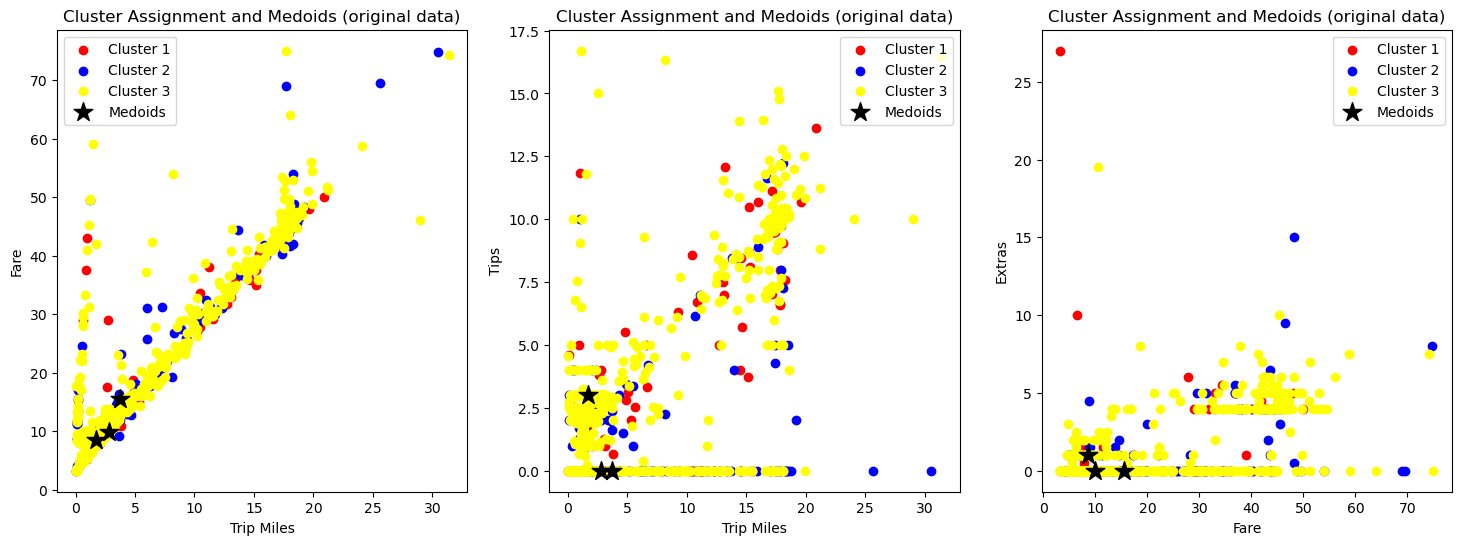

In [27]:
colors = ['red', 'blue', 'yellow']

feature_pairs = [('Trip Miles', 'Fare'), ('Trip Miles', 'Tips'), ('Fare', 'Extras')]

medoid_dict = kfold_fast_kmedoids.medoids_
medoid_coords = [medoid_dict[cluster] for cluster in medoid_dict]
medoids_df = pd.DataFrame(medoid_coords, columns=data.columns)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, (feature_x, feature_y) in enumerate(feature_pairs):
    ax = axs[i] 
    for cluster in np.unique(cluster_labels):
        cluster_data = data[cluster_labels == cluster]
        ax.scatter(cluster_data[feature_x], cluster_data[feature_y], 
                   label=f'Cluster {cluster+1}', color=colors[cluster])
    
    ax.scatter(medoids_df[feature_x], medoids_df[feature_y], 
               color='black', marker='*', s=200, label='Medoids')
    ax.set_title('Cluster Assignment and Medoids (original data)')
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.legend(loc='best')

plt.show()

Cluster visualization with the original data gives us a confusing result, as we cannot determine the clouds separately. The reason for that lies in the fact that while plotting in the original space the Generalized Gower metric doesn't reflect the true relationships between data points. Besides, the high dimensionality of the dataset complicates the interpretation. To better understand the clusters, we use **Multidimensional Scaling** to project the data into a two-dimensional space. With it, we also calculate the coordinates of medoids in this new space to plot them later.

#### 2.3. Project the data into 2-dimensional space

In [28]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto') 

GGower = GGowerDistMatrix(random_state=42, p1=p1, p2=p2, p3=p3, 
                                  d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                                  robust_method='trimmed', alpha=0.05)

D_GGower = GGower.compute(X=data)
X_mds = mds.fit_transform(D_GGower)

In [29]:
medoids = kfold_fast_kmedoids.medoids_
medoids = np.array(list(medoids.values()))
data = data.astype(float)
medoids = medoids.astype(float)

medoid_indices = []
for medoid in medoids:
    idx = np.where(np.all(data == medoid, axis=1))[0]
    if len(idx) > 0:
        medoid_indices.append(idx[0])

medoids_mds = X_mds[medoid_indices]

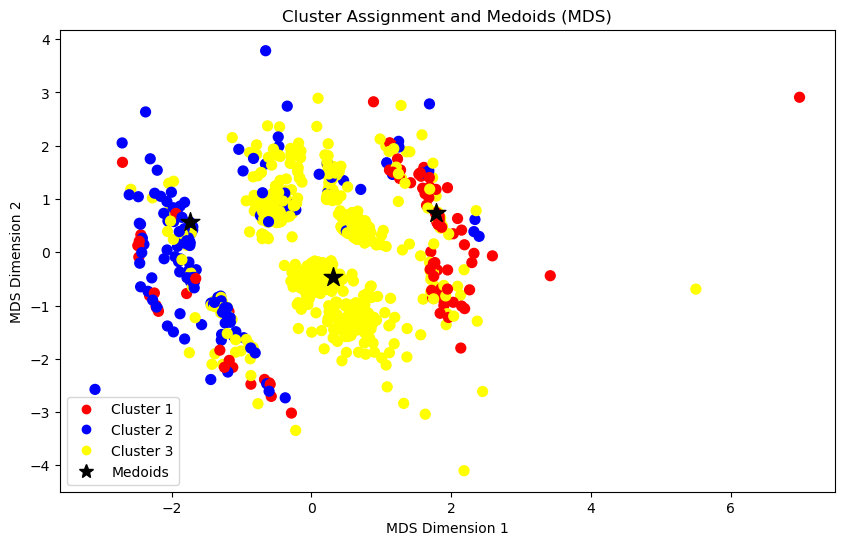

In [30]:
plt.figure(figsize=(10, 6))
cmap = ListedColormap(colors)

scatter = plt.scatter(X_mds[:, 0], X_mds[:, 1], c=cluster_labels, cmap=cmap, s=50)
plt.scatter(medoids_mds[:, 0], medoids_mds[:, 1], c='black', marker='*', s=200, label='Medoids')

handles, _ = scatter.legend_elements(prop="colors")
cluster_labels_legend = ['Cluster 1', 'Cluster 2', 'Cluster 3']
custom_handles = handles[:len(cluster_labels_legend)]

medoid_legend = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=10, label='Medoids')

plt.legend(custom_handles + [medoid_legend], 
           cluster_labels_legend + ['Medoids'])

plt.title('Cluster Assignment and Medoids (MDS)')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

#### 2.4. Interpretation of the clusters

In the plot above we can see that the data is not perfectly packed into the clusters but it's close to it. Thus, we witness three clouds of observations: the "heavy" yellow and two small ones. Next, we will use the original medoids' coordinates to attribute them to the original dataset.

In [31]:
clusters_df = pd.DataFrame(medoid_coords, columns=['Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Extras', 'Trip Total',
       'Weekend', 'Daytime', 'Payment Type', 'Company'], index=['Cluster 1', 'Cluster 2', 'Cluster 3'])
clusters_df

,Trip Seconds,Trip Miles,Fare,Tips,Extras,Trip Total,Weekend,Daytime,Payment Type,Company
Cluster 1,502.0,2.77,9.95,0.0,0.0,9.95,0.0,0.0,2.0,8.0
Cluster 2,1473.0,3.70,15.50,0.0,0.0,15.50,1.0,1.0,0.0,9.0
Cluster 3,650.0,1.71,8.50,3.0,1.0,13.00,0.0,1.0,1.0,8.0


**Cluster 1 (Red)**

In [34]:
inversed[(inversed['Encoded'] == 8) & (pd.isna(inversed['Payment Type']))]

,Encoded,Payment Type,Company
8,8,NaN,City Service


In [35]:
inversed[(inversed['Encoded'] == 2) & (pd.isna(inversed['Company']))]

,Encoded,Payment Type,Company
2,2,Mobile,NaN


This cluster contains the shortest rides in terms of time. The average ride distance is relatively small, and there are no additional charges. These rides predominantly occur on weekdays at night. The associated payment method is Mobile, and "City Service" is the most common taxi company for these trips.

**Cluster 2 (Blue)**

In [36]:
inversed[(inversed['Encoded'] == 9) & (pd.isna(inversed['Payment Type']))]

,Encoded,Payment Type,Company
9,9,NaN,Flash Cab


In [37]:
inversed[(inversed['Encoded'] == 0) & (pd.isna(inversed['Company']))]

,Encoded,Payment Type,Company
0,0,Cash,NaN


This cluster represents the longest rides (around 25 minutes) with no additional charges. The average fare is 15.5. Most of these rides occur on weekends during the daytime, with Cash being the primary payment method. The rides are typically associated with "Flash Cab", one of the largest taxi companies in Chicago.

**Cluster 3 (Yellow)**

In [38]:
inversed[(inversed['Encoded'] == 8) & (pd.isna(inversed['Payment Type']))]

,Encoded,Payment Type,Company
8,8,NaN,City Service


In [39]:
inversed[(inversed['Encoded'] == 1) & (pd.isna(inversed['Company']))]

,Encoded,Payment Type,Company
1,1,Credit Card,NaN


This is the largest cluster, consisting of short rides that take approximately 11 minutes to complete. These rides are unique in having tips averaging 3 and extra charges averaging 1. They primarily occur on weekdays during the daytime. The typical payment method is Credit Card, and the majority of rides are conducted by "City Service", one of the largest companies in Chicago.

Based on the results above we can assume what stands behind these clusters.

The rides in the **Cluster 1** primarily occur at night, suggesting minimal traffic and quick trip completions. The use of Mobile payments may imply that the main users are possibly younger riders who are more likely to have an active social life.

The **Cluster 2** is representative of general weekend rides, with no notable extras or tips. The lengthy rides and daytime timing indicate a variety of purposes, such as shopping, errands, or leisure activities. The use of Cash as the primary payment method may point to casual, unplanned trips.

The **Cluster 3** likely represents regular weekday rides taken during work hours, particularly during peak traffic times in the morning and afternoon. The presence of tips and extra charges suggests business-related rides where riders might leave tips as an expression of gratitude or due to company-paid expenses. The daytime occurrence and higher extras could also indicate longer waiting times or toll costs during traffic.

### References

Grané, A., Scielzo-Ortiz, F. **Fast k-medoids and q-Fold Fast k-medoids: New distance-based clustering algorithms for large mixed-type data**. *Journal of Classification* (submitted in 2024) https://pypi.org/project/FastKmedoids/

Grané, A., Scielzo-Ortiz, F. **PyDistances: A Python package for mixed-type data**. *SORT* (submitted in 2024) https://pypi.org/project/PyDistances/